## XceptionNet for Flower type Classification using Pytorch 

In this notebook we are going to implement the XceptionNet architecture by the great Francois Chollet. We are going to devise the entire model of it. Its very similar to the prevailing Inception Network model, but changes the convolutions with Depthwise Separable Convolutions.   

So, lets get our hands dirty in implementing the model. But, first lets do our imports.

In [1]:
## Importing necessary packages ##

import torch
import torch.nn as nn
import torchvision

from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import transforms
from torchvision.utils import make_grid
from torchvision.transforms.functional import resize 

import numpy as np
import matplotlib.pyplot as plt

Now with the imports out of the way, lets bring in our flower dataset from disc using the `ImageFolder` function.

We are going to use some augmentation and we will use transformations.

In [2]:
## Defining augmentations ##

aug = transforms.Compose([
    transforms.Resize((299 , 299)),
    transforms.ToTensor()
])

In [3]:
## Importing the flowers dataset ##

flowers_data = ImageFolder(root = 'flowers' , 
                           transform = aug)

Now with the dataset loaded, its better to check the properties a bit.

So, lets check an example of the dataset.

Label is : 0
Maximum value is : tensor(0.8510)
Minimum value is : tensor(0.)


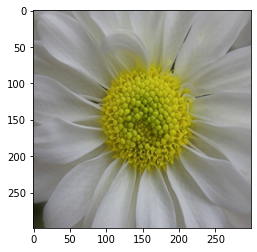

In [4]:
## Checking the dataset ##

img = flowers_data[0][0]
label = flowers_data[0][1]

print('Label is :' , label)
print('Maximum value is :' , torch.max(img))
print('Minimum value is :' , torch.min(img))

plt.imshow(img.permute(1 , 2 , 0))
plt.show()

Next up we are going to create a dataloader such that batches of data are fed in.

In [5]:
## Instantiating the dataloader ##

flowers_dataloader = DataLoader(dataset = flowers_data , 
                                batch_size = 8 ,
                                shuffle = True)

## Displaying the length of the dataloader ##

print('The length of the dataloader is :' , len(flowers_dataloader))

The length of the dataloader is : 1081


Okay!

Now its always better to visualize a batch of images.

We are going to do that now!

In [6]:
## Visualization utility function ##

def view_img(img_batch):
    
    fig , ax = plt.subplots(figsize = (4 , 2))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
    plt.imshow(make_grid(img_batch.to('cpu') , 2).permute(1 , 2, 0))

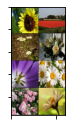

In [7]:
## Visualizing a batch of data ##

for img , label in flowers_dataloader:
    
    view_img(img)
    
    break

Now, our xception network model is pretty big to say the least and we need to compute everything using the GPU for efficiency. To do that we need to move the flowers_dataloader into the GPU.

Lets do that now!

In [8]:
## Device utility function ##

def get_device():
    
    if torch.cuda.is_available():
        
        return torch.device('cuda')
    
    return torch.device('cpu')

## Transfering data to device utility function ##

def transfer_to_device(data , device):
    
    if isinstance(data , (tuple , list)):
        
        return [transfer_to_device(each_data , device) for each_data in data]
    
    return data.to(device)

## Setting GPU Dataloader ##

class GPUDataLoader:
    
    def __init__(self , dl , device):
        
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        
        for batch in self.dl:
            
            yield transfer_to_device(batch , self.device)
            
    def __len__(self):
        
        return len(self.dl)

Now lets shift our dataloader as a GPU dataloader.

In [9]:
## Shifting to GPU Dataloader ##

device = get_device()

flowers_dl = GPUDataLoader(flowers_dataloader , device)

print('The length of the dataloader is :' , len(flowers_dl))

The length of the dataloader is : 1081


That matches with our original dataloader.

Now its better to visualize the dataloader also. So, lets do that now.

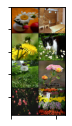

In [10]:
## Visualizing a batch of data ##

for img , label in flowers_dl:
    
    view_img(img)
    
    break

Everything is working quite well.

Now, its time that we present our star of the show, our XceptionNet model. I am going to cut short our model a bit since, well I dont have 60 X60 GPU's. :)

In [11]:
## Defining our model ##

## Defining Depthwise Separable Convolutional Block ##

class Depthwise(nn.Module):
    
    def __init__(self , in_channels , out_channels , kernel_size = 3 , stride = 1 , block = "entry"):
        
        super().__init__()
        
        self.depth_conv = nn.Sequential(nn.Conv2d(in_channels = in_channels , out_channels = out_channels , kernel_size = 1 ,
                                                  padding = 0 , stride = 1 , bias = False),
                                        nn.BatchNorm2d(out_channels),
                                        nn.Conv2d(in_channels = out_channels , out_channels = out_channels , kernel_size = 3 ,
                                                  padding = 1 , stride = 1 , groups = out_channels , bias = False),
                                        nn.BatchNorm2d(out_channels)
                                       )
        
    def forward(self , x):
        
        x = self.depth_conv(x)
        
        return x

    
## Defining the entry blocks ##

class entry_flow_block(nn.Module):
    
    def __init__(self, in_channels , out_channels):
        
        super().__init__()
        
        self.dc1 = Depthwise(in_channels , out_channels)
        self.relu = nn.ReLU()
        self.dc2 = Depthwise(out_channels , out_channels)
        self.max_pool = nn.MaxPool2d(kernel_size = 3 , stride = 2)
        
        self.short = nn.Sequential(nn.Conv2d(in_channels = in_channels , out_channels = out_channels , kernel_size = 1 , 
                                            padding = 0 , stride = 2 , bias = False),
                                   nn.BatchNorm2d(out_channels))
        
    def forward(self , x):
        
        shortcut = self.short(x)
        
        x = self.dc1(x)
        x = self.relu(x)
        x = self.dc2(x)
        x = self.max_pool(x)
        
        if x.shape != shortcut.shape:
            x = resize(x , size = shortcut.shape[2:])
        
        out = x + shortcut
        
        out = out.to(device)
        
        return out
    
## Defining the middle block ##

class middle_flow_block(nn.Module):
    
    def __init__(self, in_channels , out_channels):
        
        super().__init__()
        
        self.dc1 = Depthwise(in_channels , out_channels)
        self.relu = nn.ReLU()
        self.dc2 = Depthwise(out_channels , out_channels)
        self.dc3 = Depthwise(out_channels , out_channels)
        
    def forward(self , x):
        
        shortcut = x
        
        x = self.dc1(x)
        x = self.relu(x)
        x = self.dc2(x)
        x = self.relu(x)
        x = self.dc3(x)
        x = self.relu(x)
        
        if x.shape != shortcut.shape:
            x = resize(x , size = shortcut.shape[2:])
        
        out = x + shortcut
        
        out = out.to(device)
        
        return out
            
## Building our main model ##

class XceptionNet(nn.Module):
    
    def __init__(self , in_channels = 3, filters = [32 , 64 , 128 , 256 , 728 , 728 , 728 ,  728 , 1024 , 1536 , 2048]):
        
        super().__init__()
        
        self.in_channels = in_channels
        self.filters = filters
        self.flat = nn.Flatten()
        
        self.linear = nn.Linear(self.filters[-1] , 6)
        self.sigmoid = nn.Sigmoid()
        
        self.xception = nn.ModuleList()
        
        self.xception.append(nn.Sequential(nn.Conv2d(self.in_channels , self.filters[0] , 
                                                     kernel_size = 3 , stride = 2 , padding = 1),
                                           nn.BatchNorm2d(self.filters[0])
                                          ))
        self.xception.append(nn.Sequential(nn.Conv2d(self.filters[0] , self.filters[1] , 
                                                     kernel_size = 3 , stride = 1 , padding = 1),
                                           nn.BatchNorm2d(self.filters[1])
                                          ))
        
        for idx , each_filter in enumerate(self.filters[2 : ]):
            
            if idx <= 2 or idx == 5 or idx == 6:
                
                self.xception.append(entry_flow_block(self.filters[(idx + 2) - 1] , each_filter))
                
            elif idx > 2 and idx < 5:
                
                self.xception.append(middle_flow_block(self.filters[(idx + 2) - 1] , each_filter))
                
            else:
                
                self.xception.append(nn.Sequential(Depthwise(self.filters[(idx + 2) - 1] , each_filter),
                                                   nn.ReLU()))
                
    
    def forward(self , x):
        
        for layer in self.xception:
            
            x = layer(x)
            
            #print(x.shape)
            
        x = torch.mean(x.view(x.size(0), x.size(1), -1), dim=2)
        
        x = self.flat(x)
        
        x = self.linear(x)
        
        x = self.sigmoid(x)
        
        return x

Now lets instantiate our model and hope it works.

In [12]:
## Instantiating our model ##

model = XceptionNet()

model

XceptionNet(
  (flat): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=2048, out_features=6, bias=True)
  (sigmoid): Sigmoid()
  (xception): ModuleList(
    (0): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): entry_flow_block(
      (dc1): Depthwise(
        (depth_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=128, bias=False)
          (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_

Now we should move our model to GPU.

In [13]:
## Transferring model to GPU ##

model = model.to(device)

Lets test the model.

In [14]:
## Testing the model ##

def test():
    
    test_x = torch.randn((1 , 3 , 299 , 299)).to(device)
    
    pred = model(test_x)
    
    print(pred.shape)

In [15]:
## Checking our model ##

test()

torch.Size([1, 6])


Yes!! 

Our model is working!!

Now its time to set our optimizers and the loss function.

In [16]:
## Setting loss function ##

loss_fn = nn.CrossEntropyLoss()

## Setting optimizer ##

optim = torch.optim.Adam(model.parameters() , lr = 0.001)

Now its always better to evaluate our model.

So, let define an utility function to do just that.

In [17]:
## Defining accuracy ##

def accuracy(pred , target):
    
    pred_idx = torch.argmax(pred , dim = 1)
    
    num = torch.sum(pred_idx == target).item()
    
    den = target.numel()
    
    return num / den

Now lets define our training block for 50 epochs.

In [18]:
num_epochs = 10

acc = []

for epoch in range(num_epochs):
    
    for img , target in flowers_dl:
        
        preds = model(img)
        
        loss = loss_fn(preds , target)
        
        optim.zero_grad()
        
        loss.backward()
        
        optim.step()
        
        ac = accuracy(preds , target)
        
    acc.append(ac)
    
    print('Epoch {} / {} : Loss -> {:.3f} , Accuracy -> {:.3f}'.format(epoch + 1 , num_epochs , loss.item() , ac))
        

Epoch 1 / 10 : Loss -> 1.440 , Accuracy -> 0.500
Epoch 2 / 10 : Loss -> 1.544 , Accuracy -> 0.500
Epoch 3 / 10 : Loss -> 1.311 , Accuracy -> 0.833
Epoch 4 / 10 : Loss -> 1.544 , Accuracy -> 0.500
Epoch 5 / 10 : Loss -> 1.044 , Accuracy -> 1.000
Epoch 6 / 10 : Loss -> 1.377 , Accuracy -> 0.667
Epoch 7 / 10 : Loss -> 1.377 , Accuracy -> 0.667
Epoch 8 / 10 : Loss -> 1.710 , Accuracy -> 0.333
Epoch 9 / 10 : Loss -> 1.377 , Accuracy -> 0.667
Epoch 10 / 10 : Loss -> 1.710 , Accuracy -> 0.333
